In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

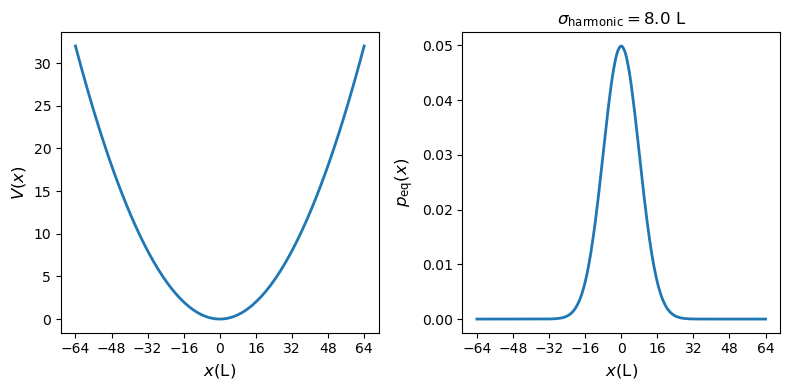

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [5]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [6]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

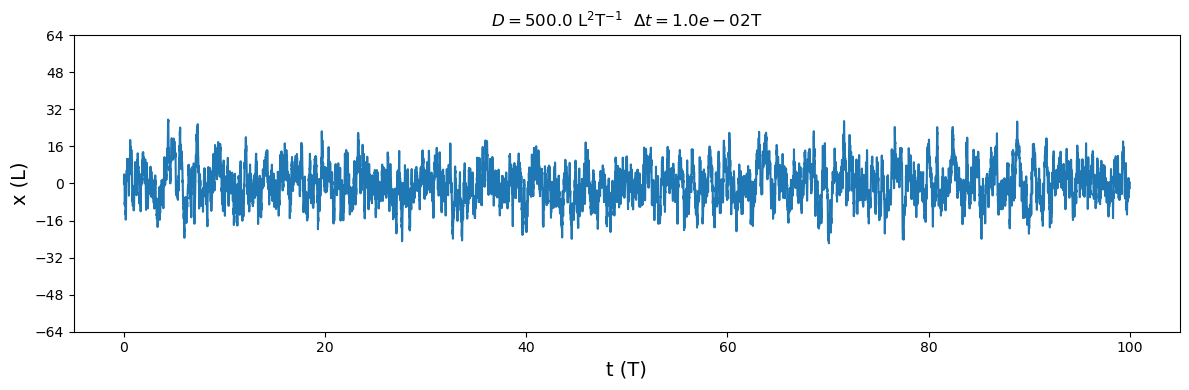

In [7]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues

In [109]:
D_test = 1000. # 500
eigenvalues, eigenvect_mat, rho_eq_by_fem = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_test, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat);

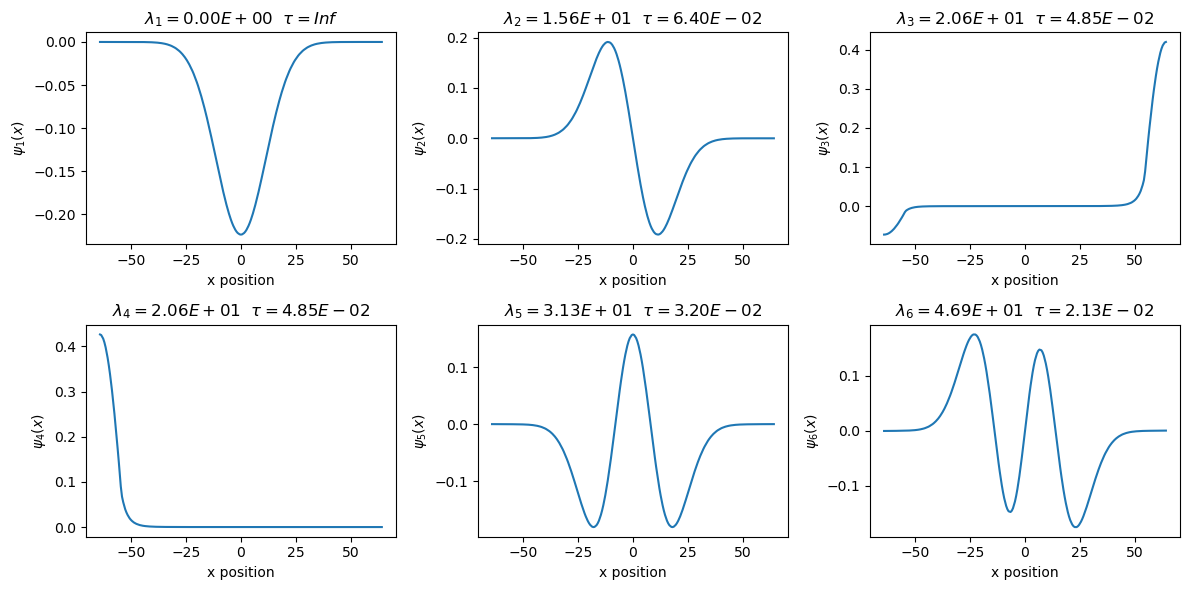

In [110]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 5: $p(x,0)$

In [111]:
σ_delta = 2.0 # 0.8
k_delta = get_k_by_sigma(σ_delta)
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
p_t0 = get_gaussian(k_delta, xref, idx)
p_t0 = p_t0 / sum(w0 .* p_t0);
sum(w0 .* p_t0)

1.0

In [112]:
alpha_t0_x = p_t0 ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t0 = transpose(weight_Qx) * alpha_t0_x
alpha_t0_norm = norm(alpha_t0);
sum(alpha_t0_x .* rho_eq .* w0)

1.0

### Part 6: $\left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t}$

In [113]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t0_e_delta_t = expLQDT .* alpha_t0;
alpha_t0_e_delta_t_norm = norm(alpha_t0_e_delta_t)
alpha_t0_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t0_e_delta_t);
p_t0_e_delta_t = alpha_t0_e_delta_t_x .* rho_eq
sum(w0 .* p_t0_e_delta_t)

0.999978208856257

### Part 7: $\left< \alpha_{t_1} \right| = \left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_1$

In [114]:
alpha_idx = 1
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t1 =  psi_photon_psi * alpha_t0_e_delta_t

alpha_t1_norm = norm(alpha_t1)
alpha_t1_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t1)
p_alpha1 = alpha_t1_x .* rho_eq
sum(w0 .* p_alpha1)

0.038870516899204496

In [115]:
# Normalization
p_alpha1_hat = p_alpha1 / sum(w0 .* p_alpha1)

alpha_t1_hat_x = p_alpha1_hat ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t1_hat = transpose(weight_Qx) * alpha_t1_hat_x
alpha_t1_hat_norm = norm(alpha_t1_hat)
sum(w0 .* p_alpha1_hat)

1.0

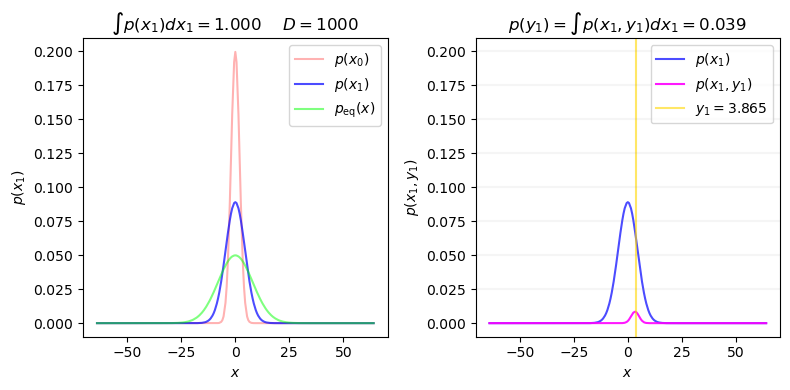

In [117]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, p_t0, alpha=0.3, color="red", label="\$p(x_0)\$")
ax.plot(xref, p_t0_e_delta_t, alpha=0.7, color="blue", label="\$p(x_1)\$")
ax.plot(xref, rho_eq .* rho_eq, alpha=0.5, color="lime", label="\$p_{\\rm{eq}}(x)\$")
ax.set_xlabel("\$x\$")
ax.set_ylabel("\$p(x_1)\$")
title = @sprintf "\$ \\int p(x_1)dx_1=%.3f\$    \$D=%d\$" sum(w0 .* p_t0_e_delta_t) D_test
ax.set_title(title)
ax.legend()
ylim = ax.get_ylim()

ax = axes[2]
ax.plot(xref, p_t0_e_delta_t, alpha=0.7, color="blue", label="\$p(x_1)\$")
ax.plot(xref, p_alpha1, alpha=0.9, color="magenta", label="\$p(x_1,y_1)\$")
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="gold", alpha=0.6, label=label)
ax.set_xlabel("\$x\$")
ax.set_ylabel("\$p(x_1,y_1)\$")
ax.legend()
for yvalue=0.025:0.025:0.2
    ax.axhline(yvalue, color="grey", alpha=0.08)
end

ax.set_ylim(ylim)
title = @sprintf "\$ p(y_1) = \\int p(x_1,y_1)dx_1=%.3f \$" sum(w0 .* p_alpha1)
ax.set_title(title)


plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/py1_D1000.svg")
plt.show()